# Introducción al Aprendizaje Automatizado: Trabajo Práctico N° 4
## Natalia Mellino

In [1]:
# imports

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier

from ej4tp1 import ej4tp1, generate_dataframe_a, generate_dataframe_b
from dimen_bayes import bayes

warnings.filterwarnings("ignore")

In [10]:
# Función para entrenar y devolver el mejor clasificador

n_vecinos = range(1, 32, 2)

def get_best_clf(x_train, y_train, x_test, y_test, x_val, y_val, w=None):
    errores_train = []
    errores_test = []
    errores_val = []
    best_e = None
    best_clf = None
    best_k = None
    

    for n in n_vecinos:
        if w is None:    
            clf = KNeighborsClassifier(n_neighbors=n)
        else:
            clf = KNeighborsClassifier(n_neighbors=n, weights=w)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        e_train = 1 - accuracy_score(y_train, y_pred_train)
        e_test = 1 - accuracy_score(y_test, y_pred)
        e_val = 1 - accuracy_score(y_val, y_pred_val)

        errores_test.append(e_test)
        errores_train.append(e_train)
        errores_val.append(e_val)

        if best_e is None or e_val < best_e:
            best_e = e_test
            best_clf = clf
            best_k = n

    return errores_train, errores_val, errores_test, best_clf

In [4]:
def graficar_predicciones(x, y, cl, title=''):
    scatter = plt.scatter(x, y, c=cl)
    plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.show()

def graficar_errores(x, et, ev, ett, title=''):
    plt.plot(x, et, label='Train')
    plt.plot(x, ev, label='Validacion')
    plt.plot(x, ett, label='Test')
    plt.title(title)
    plt.legend()
    plt.show()

## Ejercicio 1

### Utilizando el método de k-vecinos

In [13]:
def ej1():
    cols_0 = ['x', 'y', 'Class']
    cols_2 = ['x', 'y', 'z', 'w', 'Class']
    train = pd.read_csv('espirales_con_ruido/c_0.data', names=cols_0)
    ntrain = pd.read_csv('espirales_con_ruido/c_2.data', names=cols_2)
    test = pd.read_csv('espirales_con_ruido/c_0.test', names=cols_0)
    ntest = pd.read_csv('espirales_con_ruido/c_2.test', names=cols_2)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , ['x', 'y'] ], 
        train.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    x_ntrain, x_nval, y_ntrain, y_nval = train_test_split(
        ntrain.loc[ : , ['x', 'y', 'z', 'w'] ], 
        ntrain.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    ### PARA DATOS SIN RUIDO

    et, ev, ett, clf = get_best_clf(x_train, y_train, test.loc[:, ['x', 'y']], test.loc[:, ['Class']], x_val, y_val)
    y_pred = clf.predict(test.loc[:, ['x', 'y']])

    # Errores
    graficar_errores(n_vecinos, et, ev, ett, 'Error sin ruido')
    # Predicciones
    graficar_predicciones(test.loc[:, ['x']], test.loc[:, ['y']], y_pred, 'Predicciones sin ruido')

    ### PARA DATOS CON RUIDO

    net, nev, nett, nclf = get_best_clf(x_ntrain, y_ntrain, ntest.loc[:, ['x', 'y', 'z', 'w']], ntest.loc[:, ['Class']], x_nval, y_nval)
    y_npred = nclf.predict(ntest.loc[:, ['x', 'y', 'z', 'w']])

    # Errores
    graficar_errores(n_vecinos, net, nev, nett, 'Error con ruido')
    # Predicciones
    graficar_predicciones(ntest.loc[:, ['x']], ntest.loc[:, ['y']], y_npred, 'Predicciones con ruido')
    

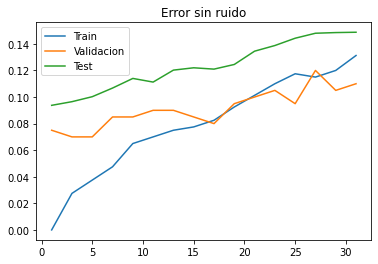

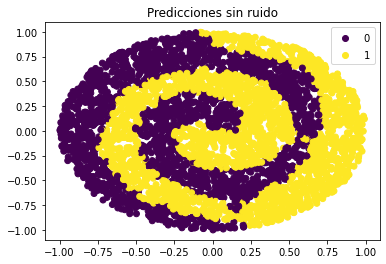

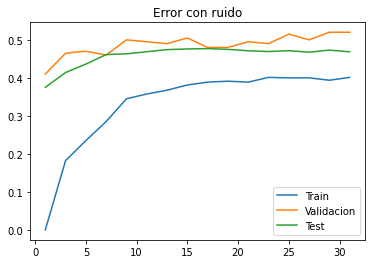

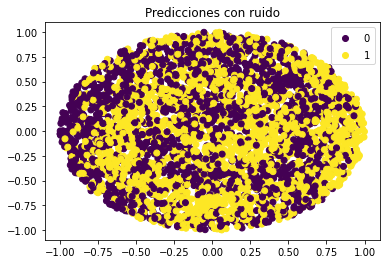

In [14]:
ej1()

Claramente podemos notar que para este problema, el método de k-vecinos resulta ser muy propenso al ruido. Sin ruido se obtiene una predicción cercana a lo esperado pero podría ser mejor. En ambos casos el error aumenta con el número k de vecinos utilizados, por lo tanto nos quedamos con los valores de k más pequeños para nuestro modelo. Este aumento del error puede deberse a que al usar un mayor valor de k, ocurre que en los bordes de la espiral, donde debería haber puntos violetas, hay puntos amarillos ya que estos son mayoría en esa zona entonces ganan la votación.

### Utilizando Árboles de Desición

In [8]:
def ej1_ad():
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    nclf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)

    cols_0 = ['x', 'y', 'Class']
    cols_2 = ['x', 'y', 'z', 'w', 'Class']
    train = pd.read_csv('espirales_con_ruido/c_0.data', names=cols_0)
    ntrain = pd.read_csv('espirales_con_ruido/c_2.data', names=cols_2)
    test = pd.read_csv('espirales_con_ruido/c_0.test', names=cols_0)
    ntest = pd.read_csv('espirales_con_ruido/c_2.test', names=cols_2)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , ['x', 'y'] ], 
        train.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    x_ntrain, x_nval, y_ntrain, y_nval = train_test_split(
        ntrain.loc[ : , ['x', 'y', 'z', 'w'] ], 
        ntrain.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    clf.fit(x_train, y_train)
    nclf.fit(x_ntrain, y_ntrain)

    ### Sin ruido

    y_pred_test = clf.predict(test.loc[ : , ['x', 'y'] ],)
    graficar_predicciones(test.loc[:, ['x']], test.loc[:, ['y']], y_pred_test, 'Predicciones sin ruido')

    ### Con ruido

    y_npred_test = nclf.predict(ntest.loc[ : , ['x', 'y', 'z', 'w'] ],)
    graficar_predicciones(ntest.loc[:, ['x']], ntest.loc[:, ['y']], y_npred_test, 'Predicciones con ruido')

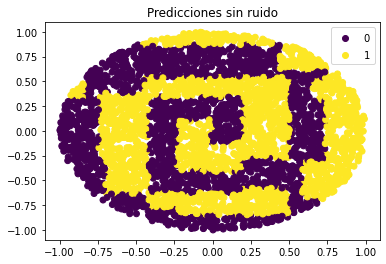

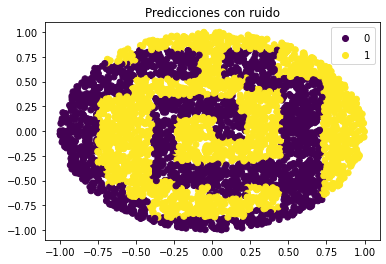

In [9]:
ej1_ad()

En el caso de los árboles de desición, podemos ver que, independientemente del error que haya tenido, los árboles no son tan suceptibles al ruido a comparación de k-vecinos. Pero como podemos ver en las predicciones, el error no es muy bueno, por lo tanto es difícil decidir cuál de los dos modelos se adapta mejor al problema. Claramente, si tenemos la garantía de que nuestros datos no son ruidosos, lo mejor es utilizar k-vecinos. Pero cuando no se puede garantizar la ausencia de ruido es más complicado.

## Ejercicio 2

In [15]:
def ej2(min_k=True):
    ds = [2, 4, 6, 8, 16, 32]

    test_errors_a = []
    test_errors_b = []
    train_errors_a = []
    train_errors_b = []

    dd = []
    for d in ds:
        for i in range(0, 20):
            dd.append(d)
            cols = list(map(str, list(range(0, d))))
            # Generamos el conjunto de testeo
            test_a = generate_dataframe_a(d = d, n = 10000, C = 0.78)
            test_set_a = test_a.loc[ : , cols ]
            y_test_set_a = test_a.loc[:, 'Class']

            test_b = generate_dataframe_b(d = d, n = 10000, C = 0.78)
            test_set_b = test_b.loc[ : , cols ]
            y_test_set_b = test_b.loc[:, 'Class']

            # Generamos el conjunto de entrenamiento
            train_set_a = generate_dataframe_a(d = d, n = 250, C = 0.78)
            train_set_b = generate_dataframe_b(d = d, n = 250, C = 0.78)


            Xtrain_a, Xval_a, ytrain_a, yval_a = train_test_split(
                train_set_a.loc[ : , cols ],
                train_set_a.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            Xtrain_b, Xval_b, ytrain_b, yval_b = train_test_split(
                train_set_b.loc[ : , cols ],
                train_set_b.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            if min_k:
                et_a, ev_a, ett_a, clf_a = get_best_clf(Xtrain_a, ytrain_a, test_set_a, y_test_set_a, Xval_a, yval_a)
                clf_a.fit(Xtrain_a, ytrain_a)

                et_b, ev_b, ett_b, clf_b = get_best_clf(Xtrain_b, ytrain_b, test_set_b, y_test_set_b, Xval_b, yval_b)
                clf_b.fit(Xtrain_b, ytrain_b)
            else:
               clf_a = KNeighborsClassifier(n_neighbors=1)
               clf_b = KNeighborsClassifier(n_neighbors=1)
               clf_a.fit(Xtrain_a, ytrain_a)
               clf_b.fit(Xtrain_b, ytrain_b)

            # Predecimos sobre el conjunto de testeo
            prediction_a = clf_a.predict(test_set_a)
            prediction_b = clf_b.predict(test_set_b)
            prediction_train_a = clf_a.predict(Xtrain_a)
            prediction_train_b = clf_b.predict(Xtrain_b)

            # Guardamos el error (1 - accuracy) sobre el conjunto de testeo
            # y el de entrenamiento.
            test_errors_a.append(1 - accuracy_score(y_test_set_a, prediction_a))
            test_errors_b.append(1 - accuracy_score(y_test_set_b, prediction_b))
            train_errors_a.append(1 - accuracy_score(ytrain_a, prediction_train_a))
            train_errors_b.append(1 - accuracy_score(ytrain_b, prediction_train_b))

    # Creamos los dataframes con cada valor de C y su respectivo error (20 errores por cada N habrá)
    df_a = pd.DataFrame({})
    df_a['d'] = dd
    df_a['Test Error'] = test_errors_a
    df_a['Train Error'] = train_errors_a

    df_b = pd.DataFrame({})
    df_b['d'] = dd
    df_b['Test Error'] = test_errors_b
    df_b['Train Error'] = train_errors_b

    # Agrupamos y calculamos el promedio de error para cada valor de C
    mean_test_error_a = df_a.groupby('d')['Test Error'].mean().to_numpy()
    mean_test_error_b = df_b.groupby('d')['Test Error'].mean().to_numpy()
    mean_train_error_a = df_a.groupby('d')['Train Error'].mean().to_numpy()
    mean_train_error_b = df_b.groupby('d')['Train Error'].mean().to_numpy()
    # Guardamos los resultados obtenidos en los dataframes
    error_df_a = pd.DataFrame({})
    error_df_a['d'] = ds
    error_df_a['Test Error'] = mean_test_error_a
    error_df_a['Train Error'] = mean_train_error_a

    error_df_b = pd.DataFrame({})
    error_df_b['d'] = ds
    error_df_b['Test Error'] = mean_test_error_b
    error_df_b['Train Error'] = mean_train_error_b

    return error_df_a, error_df_b


In [ ]:
k_diag, k_paral = ej2()


In [17]:
ad_diag, ad_paral = ej4tp1()
b_diag, b_paral = bayes()

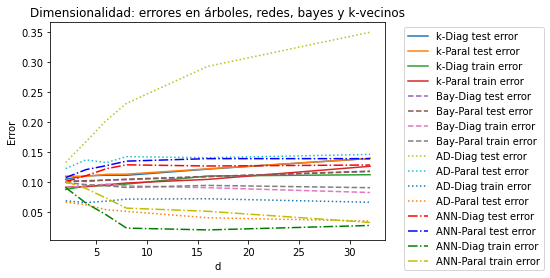

In [20]:
# K-Vecinos

plt.plot(k_diag['d'], k_diag['Test Error'], label  ='k-Diag test error')
plt.plot(k_paral['d'],k_paral['Test Error'], label ='k-Paral test error')
plt.plot(k_diag['d'], k_diag['Train Error'], label ='k-Diag train error')
plt.plot(k_paral['d'],k_paral['Train Error'], label='k-Paral train error')

# Bayes
plt.plot(b_diag['d'], b_diag['Test Error'], label='Bay-Diag test error', linestyle="--")
plt.plot(b_paral['d'], b_paral['Test Error'], label='Bay-Paral test error', linestyle="--")
plt.plot(b_diag['d'], b_diag['Train Error'], label='Bay-Diag train error', linestyle="--")
plt.plot(b_paral['d'], b_paral['Train Error'], label='Bay-Paral train error', linestyle="--")

# Arboles
plt.plot(ad_diag['d'],  ad_diag['Test Error'], label='AD-Diag test error', linestyle=":")
plt.plot(ad_paral['d'], ad_paral['Test Error'], label='AD-Paral test error', linestyle=":")
plt.plot(ad_diag['d'],  ad_diag['Train Error'], label='AD-Diag train error', linestyle=":")
plt.plot(ad_paral['d'], ad_paral['Train Error'], label='AD-Paral test error', linestyle=":")

# Redes
cols = ['d', 'Test Error', 'Train Error']
ann_error_diag = pd.read_csv('ann/diag_error.csv', names=cols)
ann_error_paral = pd.read_csv('ann/paral_error.csv', names=cols)
plt.plot(ann_error_diag['d'],  ann_error_diag['Test Error'],'r',    label='ANN-Diag test error', linestyle="-.")
plt.plot(ann_error_paral['d'], ann_error_paral['Test Error'], 'b',  label='ANN-Paral test error', linestyle="-.")
plt.plot(ann_error_diag['d'],  ann_error_diag['Train Error'], 'g',  label='ANN-Diag train error', linestyle="-.")
plt.plot(ann_error_paral['d'], ann_error_paral['Train Error'], 'y', label='ANN-Paral train error', linestyle="-.")

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('d')
plt.ylabel('Error')
plt.title("Dimensionalidad: errores en árboles, redes, bayes y k-vecinos")

plt.show()

En la gráfica de arriba podemos observar el error respecto de las dimensiones para el modelo de k-vecinos (con el k óptimo) junto con los resultados obtenidos para los otros modelos en los prácticos anteriores. Podemos ver que en este caso se acentúa mucho menos esa separación que se ve en las curvas de redes y árboles, donde los errores de train quedan muy abajo y los de test se van muy para arriba. Los resultados son mas o menos parecidos a los de bayes, siendo estos últimos los que menos crecimiento de error tuvieron al aumentar la cantidad de dimensiones.

Concluimos entonces, que el problema de las dimensiones también afecta (aunque en menor medida) en el modelo de k-vecinos.

In [17]:
k1_diag, k1_paral = ej2(False) # pasandole el parametro False hacemos que use un solo vecino


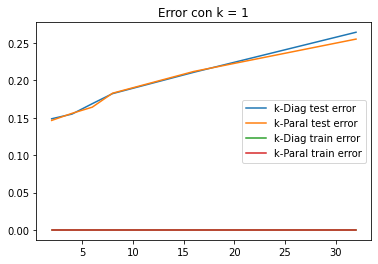

In [18]:
plt.plot(k1_diag['d'], k1_diag['Test Error'], label  ='k-Diag test error')
plt.plot(k1_paral['d'],k1_paral['Test Error'], label ='k-Paral test error')
plt.plot(k1_diag['d'], k1_diag['Train Error'], label ='k-Diag train error')
plt.plot(k1_paral['d'],k1_paral['Train Error'], label='k-Paral train error')
plt.title('Error con k = 1')
plt.legend()
plt.show()

De manera separada realizamos la gráfica de error vs dimensiones fijando el valor de k en uno. Si bien esta gráfica está en una escala distinta a la anterior donde se ven las curvas de error para el k óptimo, podemos ver que no hay mucha diferencia entre ambos valores de k. Por lo que es muy probable que nuestra función haya elegido un k cercano a 1 como el óptimo.

Otra cosa interesante de observar es lo que se da en el caso del error de train, donde tanto para el diagonal como para el paralelo, este es siempre cero. Creemos que esto se debe a que al usar k = 1, cuando predecimos sobre un punto de  nuestro conjunto de entrenamiento, vamos a obtener el único vecino más cercano del conjunto de entrenamiento, que es ese mismo punto, por lo que el error siempre será cero.

## Ejercicio 3

In [35]:
def ej3_32(k=None):
    cols = list(map(str, list(range(0, 32))))
    # Generamos el conjunto de testeo
    test_a = generate_dataframe_a(d = 32, n = 10000, C = 0.78)
    test_set_a = test_a.loc[ : , cols ]
    y_test_set_a = test_a.loc[:, 'Class']

    test_b = generate_dataframe_b(d = 32, n = 10000, C = 0.78)
    test_set_b = test_b.loc[ : , cols ]
    y_test_set_b = test_b.loc[:, 'Class']

    # Generamos el conjunto de entrenamiento
    train_set_a = generate_dataframe_a(d = 32, n = 250, C = 0.78)
    train_set_b = generate_dataframe_b(d = 32, n = 250, C = 0.78)

    # Separamos en conjunto de entrenamiento y validación
    Xtrain_a, Xval_a, ytrain_a, yval_a = train_test_split(
        train_set_a.loc[ : , cols ],
        train_set_a.loc[:, 'Class'],
        test_size=0.2, 
        random_state=0
    )

    Xtrain_b, Xval_b, ytrain_b, yval_b = train_test_split(
        train_set_b.loc[ : , cols ],
        train_set_b.loc[:, 'Class'],
        test_size=0.2, 
        random_state=0
    )

    if k is not None:
        # Usamos valor de k fijo
        clf_a = KNeighborsClassifier(n_neighbors=k, weights='distance')
        clf_b = KNeighborsClassifier(n_neighbors=k, weights='distance')
        clf_a.fit(Xtrain_a, ytrain_a)
        clf_b.fit(Xtrain_b, ytrain_b)

        y_pred_a = clf_a.predict(test_set_a)
        y_pred_train_a = clf_a.predict(Xtrain_a)
        y_pred_val_a = clf_a.predict(Xval_a)

        y_pred_b = clf_b.predict(test_set_b)
        y_pred_train_b = clf_b.predict(Xtrain_b)
        y_pred_val_b = clf_b.predict(Xval_b)

        e_train_a = 1 - accuracy_score(ytrain_a, y_pred_train_a)
        e_test_a = 1 - accuracy_score(y_test_set_a, y_pred_a)
        e_val_a = 1 - accuracy_score(yval_a, y_pred_val_a)

        e_train_b = 1 - accuracy_score(ytrain_b, y_pred_train_b)
        e_test_b = 1 - accuracy_score(y_test_set_b, y_pred_b)
        e_val_b = 1 - accuracy_score(yval_b, y_pred_val_b)

        # retornamos los errores para el k fijo
        result = {
            'diag': {
                'train': e_train_a,
                'val': e_val_a,
                'test': e_test_a
            },
            'paral': {
                'train': e_train_b,
                'val': e_val_b,
                'test': e_test_b
            }
        }

        return result
    else:
        # Si no se nos pasa un k usamos el optimizado
        et_a, ev_a, ett_a, clf_a = get_best_clf(Xtrain_a, ytrain_a, test_set_a, y_test_set_a, Xval_a, yval_a, 'distance')

        et_b, ev_b, ett_b, clf_b = get_best_clf(Xtrain_b, ytrain_b, test_set_b, y_test_set_b, Xval_b, yval_b, 'distance')

        # retornamos las listas de errores para el k optimizado
        result = {
            'diag': {
                'train': et_a,
                'val': ev_a,
                'test': ett_a,
                'clf': clf_a
            },
            'paral': {
                'train': et_b,
                'val': ev_b,
                'test': ett_b,
                'clf': clf_b
            }
        }

        return result


In [36]:
errores_kfijo = ej3_32(k = 50)
errores_kopt = ej3_32()

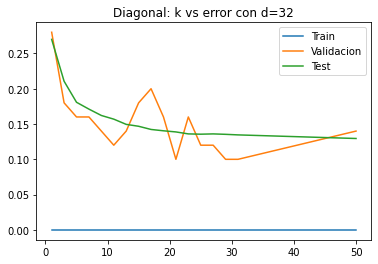

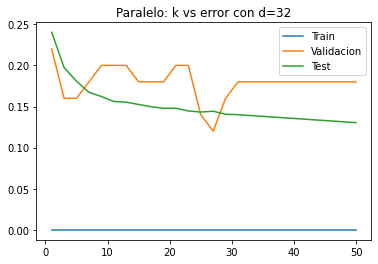

In [37]:
# Graficamos los errores del k ultimo acoplando el de k = 50 al final de las listas de errores
graficar_errores(
    list(n_vecinos) + [50], 
    errores_kopt['diag']['train'] + [errores_kfijo['diag']['train']],
    errores_kopt['diag']['val'] + [errores_kfijo['diag']['val']],
    errores_kopt['diag']['test'] + [errores_kfijo['diag']['test']], 
    'Diagonal: k vs error con d=32'
)

graficar_errores(
    list(n_vecinos) + [50], 
    errores_kopt['paral']['train'] + [errores_kfijo['paral']['train']],
    errores_kopt['paral']['val'] + [errores_kfijo['paral']['val']],
    errores_kopt['paral']['test'] + [errores_kfijo['paral']['test']], 
    'Paralelo: k vs error con d=32'
)

En este caso podemos observar resultados similares tanto para el diagonal como para el paralelo: las curvas de validacion y test son similares. En ambos casos resulta mejor el k-óptimo que el k = 50, encontrando este valor óptimo entre 20 y 30 aproximadamente. Acá también tenemos el inconveniente con la curva del train que mencionamos antes.

Otra cosa destacable es que a comparación de lo visto en espirales, donde se necesitaba un k más chico para tener menos error, acá a medida que el k va aumentando el error parece disminuir. Tal vez tenga que ver con la cantidad de espacio que hay entre los puntos al tener muchas dimensiones y el hecho de que tomar un k más grande ayuda con esta situación.

In [21]:
def ej3_dim(k=None):

    ds = [2, 4, 6, 8, 16, 32]

    test_errors_a = []
    test_errors_b = []
    train_errors_a = []
    train_errors_b = []

    dd = []
    for d in ds:
        for i in range(0, 20):
            dd.append(d)

            cols = list(map(str, list(range(0, d))))
            # Generamos el conjunto de testeo
            test_a = generate_dataframe_a(d = d, n = 10000, C = 0.78)
            test_set_a = test_a.loc[ : , cols ]
            y_test_set_a = test_a.loc[:, 'Class']

            test_b = generate_dataframe_b(d = d, n = 10000, C = 0.78)
            test_set_b = test_b.loc[ : , cols ]
            y_test_set_b = test_b.loc[:, 'Class']

            # Generamos el conjunto de entrenamiento
            train_set_a = generate_dataframe_a(d = d, n = 250, C = 0.78)
            train_set_b = generate_dataframe_b(d = d, n = 250, C = 0.78)

            # Separamos en conjunto de entrenamiento y validación
            Xtrain_a, Xval_a, ytrain_a, yval_a = train_test_split(
                train_set_a.loc[ : , cols ],
                train_set_a.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            Xtrain_b, Xval_b, ytrain_b, yval_b = train_test_split(
                train_set_b.loc[ : , cols ],
                train_set_b.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            if k is not None:
                # Usamos valor de k fijo
                clf_a = KNeighborsClassifier(n_neighbors=k, weights='distance')
                clf_b = KNeighborsClassifier(n_neighbors=k, weights='distance')
                clf_a.fit(Xtrain_a, ytrain_a)
                clf_b.fit(Xtrain_b, ytrain_b)

                y_pred_a = clf_a.predict(test_set_a)
                y_pred_train_a = clf_a.predict(Xtrain_a)
                y_pred_val_a = clf_a.predict(Xval_a)

                y_pred_b = clf_b.predict(test_set_b)
                y_pred_train_b = clf_b.predict(Xtrain_b)
                y_pred_val_b = clf_b.predict(Xval_b)

            else:
                # Si no se nos pasa un k usamos el optimizado
                et_a, ev_a, ett_a, clf_a = get_best_clf(Xtrain_a, ytrain_a, test_set_a, y_test_set_a, Xval_a, yval_a, 'distance')

                et_b, ev_b, ett_b, clf_b = get_best_clf(Xtrain_b, ytrain_b, test_set_b, y_test_set_b, Xval_b, yval_b, 'distance')

            # Predecimos sobre el conjunto de testeo
            prediction_a = clf_a.predict(test_set_a)
            prediction_b = clf_b.predict(test_set_b)
            prediction_train_a = clf_a.predict(Xtrain_a)
            prediction_train_b = clf_b.predict(Xtrain_b)

            # Guardamos el error (1 - accuracy) sobre el conjunto de testeo
            # y el de entrenamiento.
            test_errors_a.append(1 - accuracy_score(y_test_set_a, prediction_a))
            test_errors_b.append(1 - accuracy_score(y_test_set_b, prediction_b))
            train_errors_a.append(1 - accuracy_score(ytrain_a, prediction_train_a))
            train_errors_b.append(1 - accuracy_score(ytrain_b, prediction_train_b))

    # Creamos los dataframes con cada valor de C y su respectivo error (20 errores por cada N habrá)
    df_a = pd.DataFrame({})
    df_a['d'] = dd
    df_a['Test Error'] = test_errors_a
    df_a['Train Error'] = train_errors_a

    df_b = pd.DataFrame({})
    df_b['d'] = dd
    df_b['Test Error'] = test_errors_b
    df_b['Train Error'] = train_errors_b

    # Agrupamos y calculamos el promedio de error para cada valor de C
    mean_test_error_a = df_a.groupby('d')['Test Error'].mean().to_numpy()
    mean_test_error_b = df_b.groupby('d')['Test Error'].mean().to_numpy()
    mean_train_error_a = df_a.groupby('d')['Train Error'].mean().to_numpy()
    mean_train_error_b = df_b.groupby('d')['Train Error'].mean().to_numpy()
    # Guardamos los resultados obtenidos en los dataframes
    error_df_a = pd.DataFrame({})
    error_df_a['d'] = ds
    error_df_a['Test Error'] = mean_test_error_a
    error_df_a['Train Error'] = mean_train_error_a

    error_df_b = pd.DataFrame({})
    error_df_b['d'] = ds
    error_df_b['Test Error'] = mean_test_error_b
    error_df_b['Train Error'] = mean_train_error_b

    return error_df_a, error_df_b
 

In [22]:
errores_kfijo_diag, errores_kfijo_paral = ej3_dim(k=50)
errores_kopt_diag, errores_kopt_paral = ej3_dim()

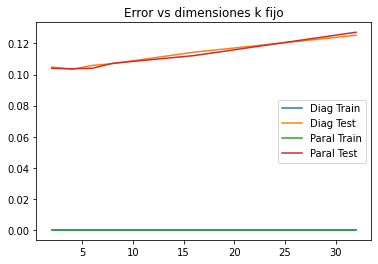

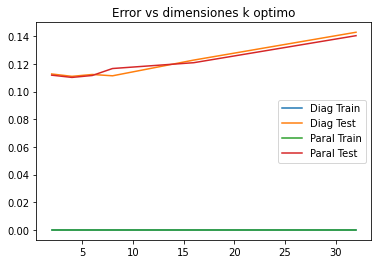

In [23]:
dims = [2, 4, 6, 8, 16, 32]
plt.plot(dims, errores_kfijo_diag['Train Error'], label='Diag Train')
plt.plot(dims, errores_kfijo_diag['Test Error'], label='Diag Test')
plt.plot(dims, errores_kfijo_paral['Train Error'], label='Paral Train')
plt.plot(dims, errores_kfijo_paral['Test Error'], label='Paral Test')
plt.title('Error vs dimensiones k fijo')
plt.legend()
plt.show()

plt.plot(dims, errores_kopt_diag['Train Error'], label='Diag Train')
plt.plot(dims, errores_kopt_diag['Test Error'], label='Diag Test')
plt.plot(dims, errores_kopt_paral['Train Error'], label='Paral Train')
plt.plot(dims, errores_kopt_paral['Test Error'], label='Paral Test')
plt.title('Error vs dimensiones k optimo')
plt.legend()
plt.show()

Ahora, con respecto al error vs dimensiones, el erorr de test en k-fijo es apenas un poco mejor que el k óptimo ya que alcanza valores un poco más bajos. Sin embargo, para ambos problemas, más allá de la diferencia de valores, se pueden observar resultados mas o menos similares. En este caso, viendo las curvas de validación test podemos comprobar que también afecta a nuestro modelo la cantidad de dimensiones y funciona mejor cuando hay menos.

Otra cosa a notar, es que en este caso estamos usando distancia y también podemos ver que la linea de train se hace nula. Esto tiene que ver con algo parecido a lo dicho anteriormente: al predecir sobre el conjunto de train y tomar un ejemplo, como este mismo ejemplo sobre el que estamos prediciendo pertenece al los datos que tiene nuestro modelo para hacer la predicción, vamos a obtener que el punto mas cercano es ese mismo por lo que la distancia siempre será cero, y (según lo leído en el libro de Mitchell) se asignará la clasificación que obtuvo ese mismo punto en train, y como ambos son siempre el mismo punto, el error siempre va a ser nulo.

## Ejercicio 4

In [24]:
n_vecinos = range(1, 32, 2)
def get_best_clf_regressor(x_train, y_train, x_test, y_test, x_val, y_val, w):

    # w = 'uniform' o 'distance'

    errores_train = []
    errores_test = []
    errores_val = []
    best_e = None
    best_clf = None
    

    for n in n_vecinos:    
        clf = KNeighborsRegressor(n_neighbors=n, weights=w)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        e_train = mean_squared_error(y_train, y_pred_train)
        e_test = mean_squared_error(y_test, y_pred)
        e_val = mean_squared_error(y_val, y_pred_val)

        errores_test.append(e_test)
        errores_train.append(e_train)
        errores_val.append(e_val)

        if best_e is None or e_val < best_e:
            best_e = e_test
            best_clf = clf

    return errores_train, errores_val, errores_test, best_clf

In [25]:
def ej4(dataset_train, dataset_test, cols, w, title, delim=False):
    train = pd.read_csv(dataset_train, names=cols, delim_whitespace=delim)
    test = pd.read_csv(dataset_test, names=cols, delim_whitespace=delim)

    l = len(cols)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , cols[0 : (l - 1)] ], 
        train.loc[ : , [l - 1] ], 
        test_size=0.2, 
        random_state=0
    )

    x_test = test.loc[ : , cols[0 : (l - 1)] ]
    y_test = test.loc[ : , [l - 1] ]

    et, ev, ett, clf = get_best_clf_regressor(x_train, y_train, x_test, y_test, x_val, y_val, w)

    graficar_errores(n_vecinos, et, ev, ett, title)


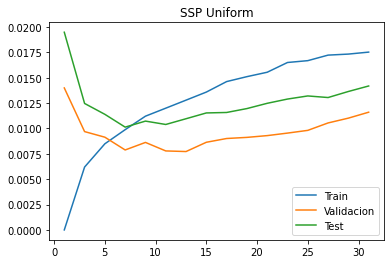

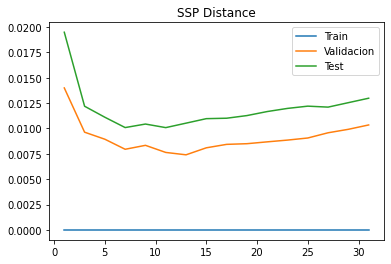

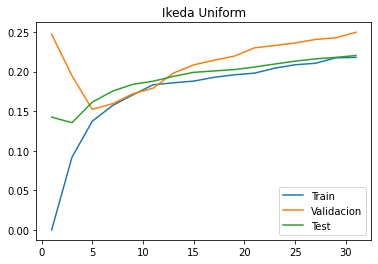

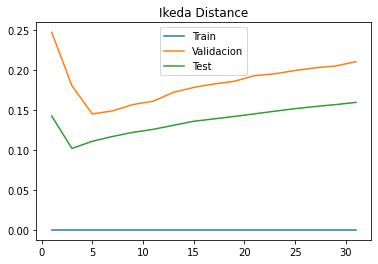

In [26]:
## SSP Uniform
ej4('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'uniform', 'SSP Uniform')

## SSP Distance
ej4('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'distance', 'SSP Distance')

## Ikeda Uniform
ej4('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'uniform', 'Ikeda Uniform', True)

## Ikeda Distance
ej4('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'distance', 'Ikeda Distance', True)

Podemos notar acá dos cosas interesantes:

- En SSP el modelo funciona mejor, podemos ver que logramos valores de error muy buenos. En cambio en Ikeda no se comporta de la mejor manera.
- Utilizando pesado inverso a la distancia, tanto en Ikeda como en SSP, se produce el mismo fenómeno mencionado en los ejercicios anteriores por lo que la curva de train siempre la tendremos nula.

Por otro lado, en comparación respecto a redes neuronales vimos que en ambos casos los resultados obtenidos con redes son ligeramente mejores. Mostramos a continuación la gráfica de los resultados de redes para mejor visualización:

**Ikeda**
![image](ikeda.png)

**SSP**
![image](ssp.png)

## Ejercicio 6

In [55]:
radios = list(np.arange(0.80, 5, 0.3)) # con un valor menor a 0.8 tira error
def get_best_clf_regressor_6(x_train, y_train, x_test, y_test, x_val, y_val, w):

    # w = 'uniform' o 'distance'

    errores_train = []
    errores_test = []
    errores_val = []
    best_e = None
    best_clf = None
    

    for r in radios:    
        clf = RadiusNeighborsRegressor(radius=r, weights=w)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        e_train = mean_squared_error(y_train, y_pred_train)
        e_test = mean_squared_error(y_test, y_pred)
        e_val = mean_squared_error(y_val, y_pred_val)

        errores_test.append(e_test)
        errores_train.append(e_train)
        errores_val.append(e_val)

        if best_e is None or e_val < best_e:
            best_e = e_test
            best_clf = clf

    return errores_train, errores_val, errores_test, best_clf

In [47]:
def ej6(dataset_train, dataset_test, cols, w, title, delim=False):
    train = pd.read_csv(dataset_train, names=cols, delim_whitespace=delim)
    test = pd.read_csv(dataset_test, names=cols, delim_whitespace=delim)

    l = len(cols)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , cols[0 : (l - 1)] ], 
        train.loc[ : , [l - 1] ], 
        test_size=0.2, 
        random_state=0
    )

    x_test = test.loc[ : , cols[0 : (l - 1)] ]
    y_test = test.loc[ : , [l - 1] ]

    et, ev, ett, clf = get_best_clf_regressor_6(x_train, y_train, x_test, y_test, x_val, y_val, w)

    graficar_errores(radios, et, ev, ett, title)

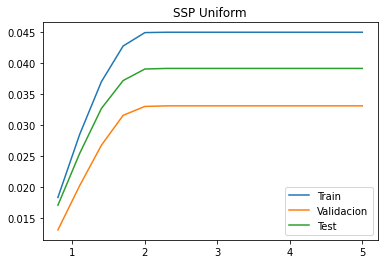

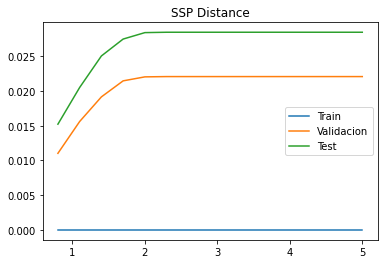

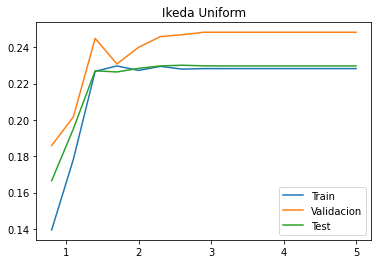

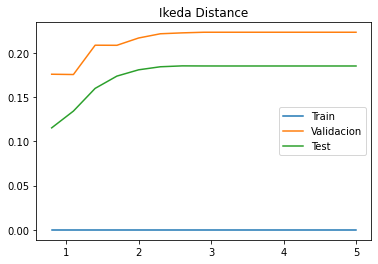

In [56]:
## SSP Uniform
ej6('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'uniform', 'SSP Uniform')

## SSP Distance
ej6('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'distance', 'SSP Distance')

## Ikeda Uniform
ej6('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'uniform', 'Ikeda Uniform', True)

## Ikeda Distance
ej6('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'distance', 'Ikeda Distance', True)

Ahora, utilizando la cantidad de vecinos en un radio, fuimos ajustando el valor del radio r para encontrar el mejor modelo. Podemos notar un par de cosas:

- En SSP, el modelo funciona mucho mejor que en Ikeda, en este último se obtienen valores de error bastante altos.
- No se observa sobreajuste.
- Ocurre el mismo fenómeno mencionado en los ejercicios anteriores con la curva de train.
- Con respecto a la superioridad de vecinos sobre un radio vs k vecinos, no se destaca un método por sobre el otro ya que los valores de error para k/r óptimos son similares.
- A partir de un r igual o mayor a 2 la curva de error se 'plancha', es decir, lo ideal es tener un radio menor a 1 ya que allí es donde se obtienen los mejores valores para el error.